## Data Science Central Challenge: Identifying patterns in complex time series 
#### by Rohan Kotwani

### http://www.datasciencecentral.com/forum/topics/challenge-of-the-week-identifying-patterns-in-complex-time-series

#### Solution
"Solution to the 9/26/15 challenge of the week: identifying patterns in complex time series. The data is pageviews for one of our websites. Click here to download a bigger data set, involving multiple websites, page view and session metrics (session is a more reliable metric in this context), for a longer time period. The time series has a weekly periodicity with two peaks: Monday and Thursday, corresponding respectively to the publication of the Monday and Thursday digests. The impact of the Monday and Thursday email blasts extent over the next day; this makes measuring the yield more difficult, unless you use additional data, e.g. from our newsletter vendor. However, the bulk of the impact is really on Monday and Thursday. Some weeks, Wednesday or Friday or even Saturday can be our best day: it usually means that we have published an article that is even more popular than the digests, or that we got featured in a very popular news outlet, or that a bot got undetected by Google Analytics, explaining a spike in pageviews (but not in sessions). When this happens on a Monday or Thursday, it makes for an unusually high peak."

#### How I attempted the problem
I fitted a regression model which accounted for trend and seasonality.

** y = P(t) + S(t) + T(t) + R(t)**
* P(t)~Polynomial component
* S(t)~Seasonal component
* T(t)~Trend component
* R(t)~Residual error

600 observations were used in the training set. The result was tested on the full dataset with 731 observations.


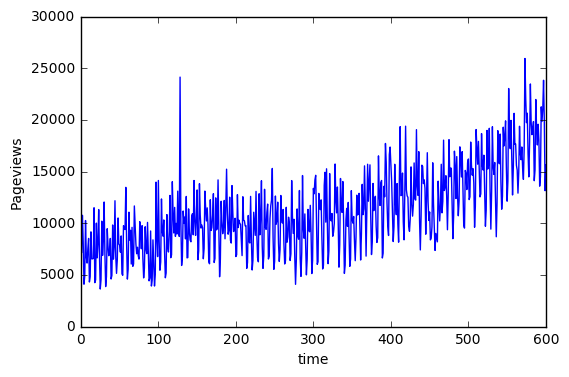

In [128]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import datetime

full=pd.read_csv("DATA/DSC_Time_Series_Challenge.csv",dtype = {'Day ':str,'Sessions':int,'Pageviews':int})
time=[datetime.datetime.strptime(t[0],"%m/%d/%y") for t in full[['Day ']].values]
weekday=[datetime.datetime.strptime(t[0],"%m/%d/%y").isocalendar()[2] for t in full[['Day ']].values]
month=[datetime.datetime.strptime(t[0],"%m/%d/%y").month for t in full[['Day ']].values]


full['time']=time
full['index']=np.arange(1,len(full)+1)
full['sq_index']=np.power((np.arange(1,len(full)+1)),2)
full['weekday']=weekday

full['month']=month

time_component='index'
seasonal_list=['weekday','month']

for seasonal_component in seasonal_list:
    minsec=min(full[seasonal_component])
    maxsec=max(full[seasonal_component])
    full[seasonal_component]=full[seasonal_component].apply(lambda x: (x - minsec)+1)

full=full.sort_values(by=[time_component])
train=full[:600].copy()

plt.plot(train['index'],train['Pageviews'],'-')
plt.xlabel('time')
plt.ylabel('Pageviews')
plt.show()

In [129]:
def filter_trend(unfiltered,band,f_signal,threshold):
    filtered=[]
    for x,f in unfiltered:
        if np.absolute(f)>f_signal+band or np.absolute(f)<f_signal-band or (2.0/N *np.abs(x))<=threshold:
            pass
        else:
            filtered.append((f,x))
    return np.array(filtered)

## Find the overall trend:

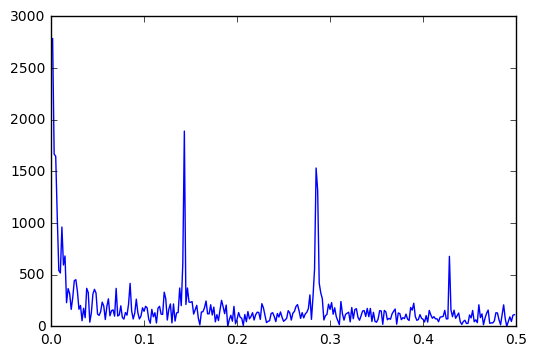

[[  1.41666667e-01   1.82239797e+05]
 [  1.43333333e-01   5.67160341e+05]
 [  2.83333333e-01   1.66899918e+05]
 [  2.85000000e-01   4.59942544e+05]
 [  2.86666667e-01   3.95441559e+05]
 [  4.28333333e-01   2.03492985e+05]]


In [130]:
yf = np.fft.fft(train['Pageviews'])
freq= np.fft.fftfreq(len(yf))
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
y_abs=( 2.0/N * np.abs(yf[:N//2]))

plt.plot(freq[1:N//2],2.0/N * np.abs(yf[1:N//2]))
plt.show()


n=len(train)
F_unfiltered  = np.column_stack((yf[1:n//2],freq[1:n//2]))
print(np.absolute(filter_trend(F_unfiltered, 0.2,0.3,500)))

## Does it make sense to reuse frequencies for the trend and seasonal components?

* On one hand, it might be better not to miss anything. I doubt there will be a prominant trend for -a weekday- every 28 weeks.
* For the trend component, it would makes sense to use the lowest frequencies with the highest magnitudes.
* For the seasonal component, there is an "interesting" frequencies around .143, .285, and .428.

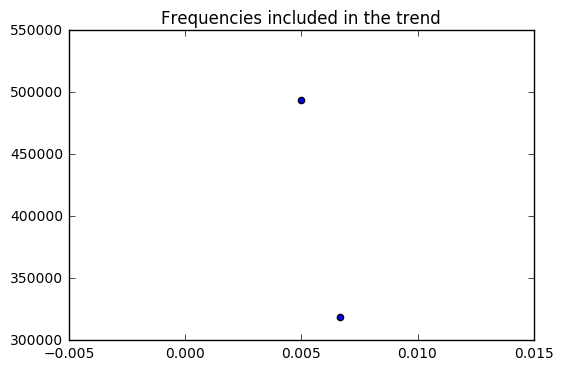

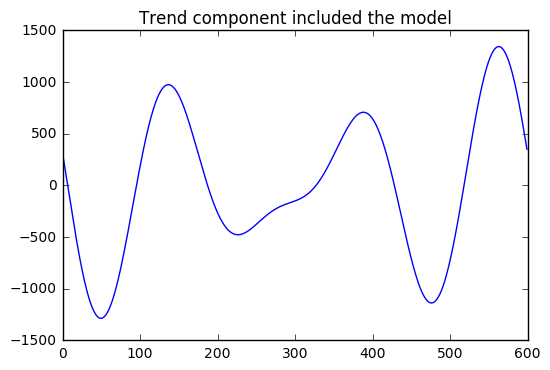

In [131]:
n=len(train)

F_unfiltered  = np.column_stack((yf[1:n//2],freq[1:n//2]))

F_filtered = filter_trend(F_unfiltered, 0.05,0.055,1000)

signal=np.zeros(len(train))
t=np.arange(0,len(train))
t_full=np.arange(0,len(full))
signal_full=np.zeros(len(full))
for i,x in F_filtered:
    magnitude=np.absolute(x)/n
    f=np.absolute(i)
    phase=np.angle(x)
    signal+= magnitude * np.cos(2*np.pi*t*f+phase)
    signal_full+= magnitude * np.cos(2*np.pi*t_full*f+phase)
train['trend']=signal
full['trend']=signal_full

plt.scatter((np.absolute(F_filtered)[:,0]),
        (np.absolute(F_filtered)[:,1]))
plt.title("Frequencies included in the trend")
plt.show()

plt.plot(t,signal,'-')
plt.title('Trend component included the model')
plt.show()

## Finding seasonal patterns:

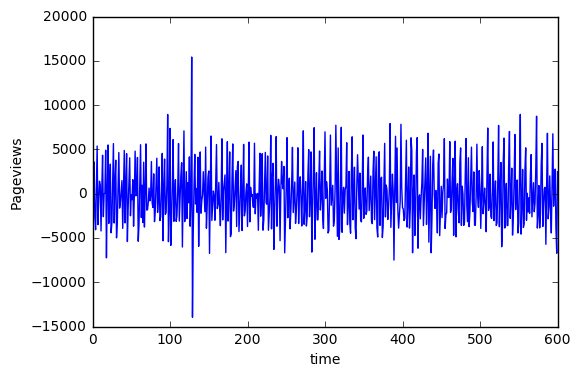

In [134]:
temp={}
temp['Pageviews_l']=[]
for t in range(len(train)):
    if t>0:
        #temp['Pageviews_l'+str(i)].append()
        temp['Pageviews_l'].append(train.ix[t]['Pageviews']-train.ix[t-1]['Pageviews'])
        #print(train.ix[t]['S'+str(i)]-train.ix[t-1]['S'+str(i)])
    else:
        temp['Pageviews_l'].append(0)
train['Pageviews_l']=temp['Pageviews_l']
plt.plot(train['index'],train['Pageviews_l'],'-')
plt.xlabel('time')
plt.ylabel('Pageviews')
plt.show()

### The overall trend could be removed by creating a differenced variable for Pageviews The differenced variable allows for seasonal components to be identified more clearly.

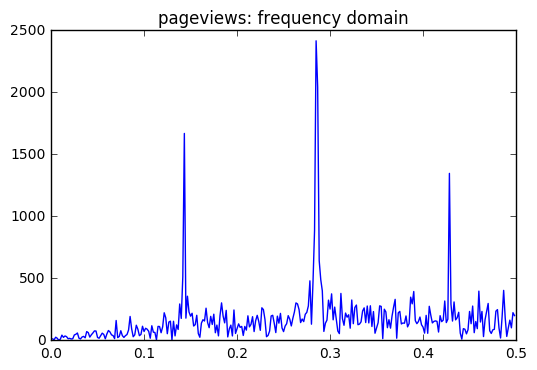

[[  1.43333333e-01   5.00831933e+05]
 [  2.83333333e-01   2.65832489e+05]
 [  2.85000000e-01   7.24904464e+05]
 [  2.86666667e-01   6.13035227e+05]
 [  2.88333333e-01   1.92922452e+05]
 [  4.28333333e-01   4.04206565e+05]]


In [136]:
yf = np.fft.fft(train['Pageviews_l'])
freq= np.fft.fftfreq(len(yf))
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
y_abs=( 2.0/N * np.abs(yf[:N//2]))

plt.plot(freq[1:N//2],2.0/N * np.abs(yf[1:N//2]))
plt.title("pageviews: frequency domain")
plt.show()

threshold = np.mean(2.0/N * np.abs(yf[1:N//2]))+2*np.std(2.0/N * np.abs(yf[1:N//2]))
n=len(train)
F_unfiltered  = np.column_stack((yf[1:n//2],freq[1:n//2]))
print(np.absolute(filter_trend(F_unfiltered, 0.2,0.3,threshold)))

#### The lower frequency components were removed and the other, distinct frequencies were amplified.

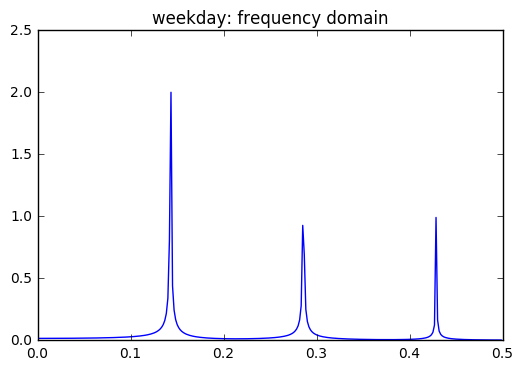

[[  1.41666667e-01   2.42782136e+02]
 [  1.43333333e-01   6.00386477e+02]
 [  1.45000000e-01   1.31981640e+02]
 [  2.85000000e-01   2.78344410e+02]
 [  2.86666667e-01   2.07887576e+02]
 [  4.28333333e-01   2.97539156e+02]]


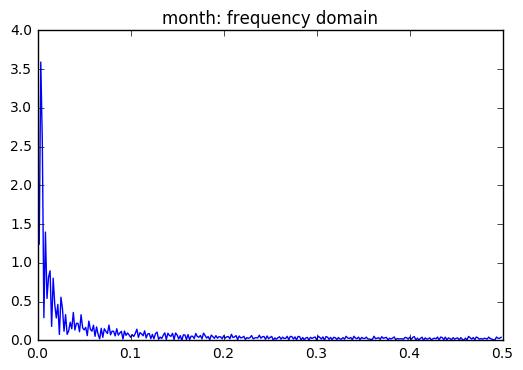

[[  1.66666667e-03   3.72830492e+02]
 [  3.33333333e-03   1.07762438e+03]
 [  5.00000000e-03   7.67352088e+02]
 [  8.33333333e-03   4.19453443e+02]
 [  1.16666667e-02   2.44623952e+02]
 [  1.33333333e-02   2.69715273e+02]
 [  1.66666667e-02   2.40980263e+02]]


In [137]:
for seasonal_component in seasonal_list:

    yf = np.fft.fft(train[seasonal_component])
    freq= np.fft.fftfreq(len(yf))
    xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
    y_abs=( 2.0/N * np.abs(yf[:N//2]))
    #Threshold is set to two standard deviations above mean
    threshold = np.mean(2.0/N * np.abs(yf[1:N//2]))+2*np.std(2.0/N * np.abs(yf[1:N//2]))
    plt.plot(freq[1:N//2],2.0/N * np.abs(yf[1:N//2]))
    plt.title(seasonal_component+": frequency domain")
    plt.show()


    n=len(train)
    F_unfiltered  = np.column_stack((yf[1:n//2],freq[1:n//2]))
    print(np.absolute(filter_trend(F_unfiltered, 0.299,0.3,threshold)))

## Eureka! Weekday shares the same frequency components as Pageviews!
I found dominant frequencies at .143, .285, and .428. These correspond to T=7.14,3.5, and 2.33. There were also some frequencies around the e-3 orders of magnitude. These were at .00166, .00333, and 0.005 and had periods upwards of 200.

In [138]:
weekday_dummies = pd.get_dummies(full.weekday, prefix='W').iloc[:, 1:]
full = pd.concat([full, weekday_dummies], axis=1)
full=full.sort_values(by=[time_component])
train=full[:600].copy()
train.head()

,Day,Sessions,Pageviews,time,index,sq_index,weekday,month,trend,W_2,W_3,W_4,W_5,W_6,W_7
0,9/25/13,4370,7177,2013-09-25,1,1,3,9,304.221820,0.0,1.0,0.0,0.0,0.0,0.0
1,9/26/13,5568,10760,2013-09-26,2,4,4,9,257.168205,0.0,0.0,1.0,0.0,0.0,0.0
2,9/27/13,4321,8171,2013-09-27,3,9,5,9,209.818345,0.0,0.0,0.0,1.0,0.0,0.0
3,9/28/13,2378,4093,2013-09-28,4,16,6,9,162.235984,0.0,0.0,0.0,0.0,1.0,0.0
4,9/29/13,2612,4881,2013-09-29,5,25,7,9,114.485143,0.0,0.0,0.0,0.0,0.0,1.0


#### recreating the seasonal list variable to include true seasonal patterns...

In [139]:
seasonal_list = ['weekday']

In [140]:
input_df2=train[seasonal_list]
output=train[['Pageviews']]
y=output.values
input_=input_df2.values
m,n =np.shape(input_)
x=input_

frequency_components=np.array([.1433,.2855,.428])
frequency_components = 2*np.pi*np.outer(frequency_components,np.ones(x.shape[1])).reshape((len(frequency_components),x.shape[1]))

trig_args = np.dot(frequency_components,x.T ).T
seasonal_x = np.column_stack((np.sin(trig_args),np.cos(trig_args)))

m,n =np.shape(seasonal_x)
# print(seasonal_x)
x=np.ones((m,n+3))
x[:,1:]=np.column_stack((seasonal_x,train['trend'],train['sq_index']))


A=x.T.dot(x)
b=x.T.dot(y)
z = np.linalg.solve(A,b)

SSE=np.sum((y-x.dot(z))**2)
print("SSE :",SSE)
print("Baseline: ",sum((y-np.mean(y))**2)[0])

SSE : 1824619798.78
Baseline:  9765197379.99


SSE:  1824619798.78
SST:  9765197379.99
R^2:  0.813150750796


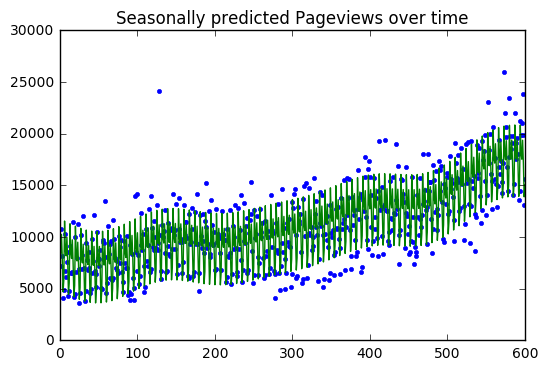

array([[  8.10030680e+03],
       [  1.55909280e+03],
       [  2.23320858e+03],
       [  1.52632878e+02],
       [ -1.26500151e+03],
       [ -3.93921325e+02],
       [ -7.03090816e+02],
       [  7.94011068e-01],
       [  2.50742897e-02]])

In [141]:
SSE=np.sum((y-x.dot(z))**2)
SST=sum((y-np.mean(y))**2)[0]
print("SSE: ",SSE)
print("SST: ",SST)
print("R^2: ",1-SSE/SST)


plt.plot(train['index'],y,'.')
plt.plot(train['index'],x.dot(z),'-')
plt.title("Seasonally predicted Pageviews over time")
plt.show()
z

## Which weekdays are the peaks located at? 

In [142]:
peaks=[]
for i,xz in enumerate(x.dot(z)):
    if i>0 and i<len(x.dot(z))-1:
        if x.dot(z)[i]>x.dot(z)[i-1] and x.dot(z)[i]>x.dot(z)[i+1]:
            peaks.append(train['time'][i].isocalendar()[2])
print("peaks: ",np.unique(peaks))


peaks:  [1 4]


## Are the peaks getting smaller over time?

### After accounting for seasonality and trend, the peaks seem to be a little bit smaller towards the end.

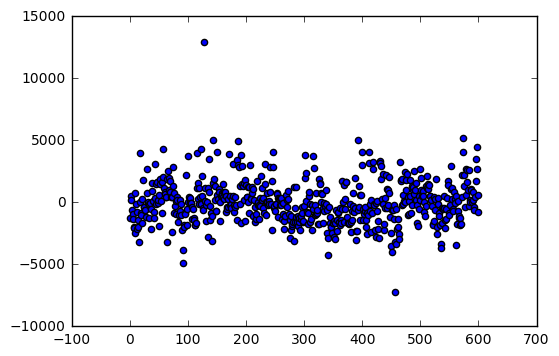

In [143]:
plt.scatter(train['index'],y-x.dot(z))
plt.show()

### The residual plot is not indicative of a major seasonal pattern. There is a slight hump at the begining that levels off and increases slightly toward the end.

## How does effective is the model on the full dataset?

SSE:  3108518427.82
SST:  21103815266.6
R^2:  0.852703485671


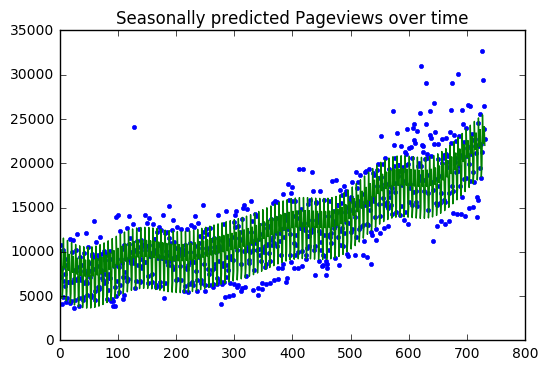

In [144]:
input_df2=full[seasonal_list]
output=full[['Pageviews']]
y=output.values
input_=input_df2.values
m,n =np.shape(input_)
x=input_

frequency_components=np.array([.1433,.285,.428])
frequency_components = 2*np.pi*np.outer(frequency_components,np.ones(x.shape[1])).reshape((len(frequency_components),x.shape[1]))

trig_args = np.dot(frequency_components,x.T ).T
seasonal_x = np.column_stack((np.sin(trig_args),np.cos(trig_args)))

m,n =np.shape(seasonal_x)
m,n =np.shape(seasonal_x)
# print(seasonal_x)
x=np.ones((m,n+3))
x[:,1:]=np.column_stack((seasonal_x,full['trend'],full['sq_index']))

SSE=np.sum((y-x.dot(z))**2)
SST=sum((y-np.mean(y))**2)[0]
print("SSE: ",SSE)
print("SST: ",SST)
print("R^2: ",1-SSE/SST)

plt.plot(full['index'],full[['Pageviews']],'.')
plt.plot(full['index'],x.dot(z),'-')
plt.title("Seasonally predicted Pageviews over time")
plt.show()



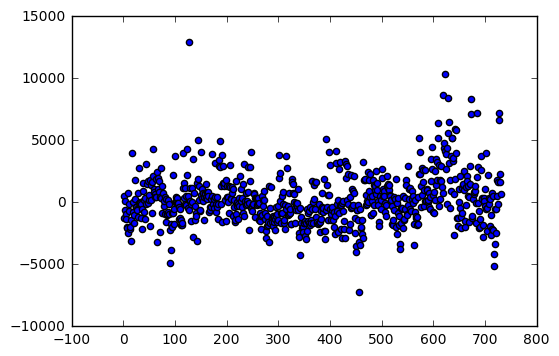

In [145]:
plt.scatter(full['index'],y-x.dot(z))
plt.show()

### There is a slightly overall trend in the residual plot. Including lower frequency components could help stablize errors.

## What about dummy coding weekday categorically?

SSE:  1824619798.78
SST:  9765197379.99
R^2:  0.813150750796


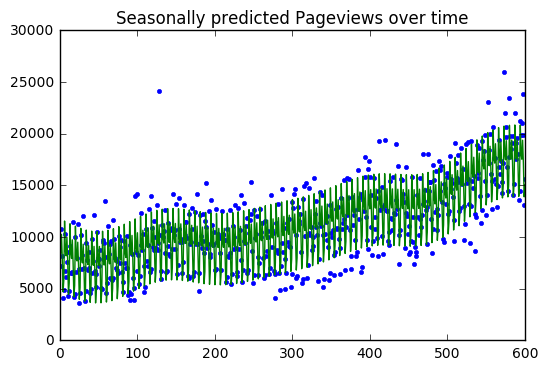

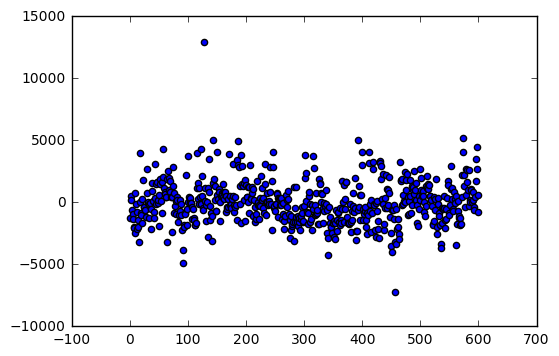

In [146]:
input_df2=train[seasonal_list]
output=train[['Pageviews']]
y=output.values
input_=input_df2.values
m,n =np.shape(input_)
x=input_

x=np.ones((m,9))
x[:,1:]=np.column_stack((train['W_2'],train['W_3'],
                         train['W_4'],train['W_5'],train['W_6'],
                         train['W_7'],train['trend'],train['sq_index']))


A=x.T.dot(x)
b=x.T.dot(y)
z = np.linalg.solve(A,b)

SSE=np.sum((y-x.dot(z))**2)
SST=sum((y-np.mean(y))**2)[0]
print("SSE: ",SSE)
print("SST: ",SST)
print("R^2: ",1-SSE/SST)


plt.plot(train['index'],y,'.')
plt.plot(train['index'],x.dot(z),'-')
plt.title("Seasonally predicted Pageviews over time")
plt.show()

plt.scatter(train['index'],y-x.dot(z))
plt.show()

SSE:  3105315115.57
SST:  21103815266.6
R^2:  0.852855273971


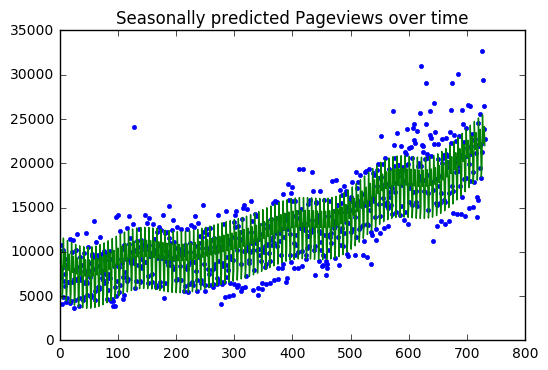

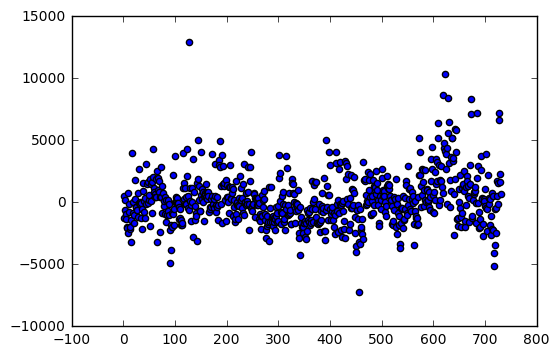

In [147]:
input_df2=full[seasonal_list]
output=full[['Pageviews']]
y=output.values
input_=input_df2.values
m,n =np.shape(input_)
x=input_

x=np.ones((m,9))
x[:,1:]=np.column_stack((full['W_2'],full['W_3'],
                         full['W_4'],full['W_5'],full['W_6'],
                         full['W_7'],full['trend'],full['sq_index']))



SSE=np.sum((y-x.dot(z))**2)
SST=sum((y-np.mean(y))**2)[0]
print("SSE: ",SSE)
print("SST: ",SST)
print("R^2: ",1-SSE/SST)


plt.plot(full['index'],full[['Pageviews']],'.')
plt.plot(full['index'],x.dot(z),'-')
plt.title("Seasonally predicted Pageviews over time")
plt.show()

plt.scatter(full['index'],y-x.dot(z))
plt.show()

### The results are almost (if not) exactly the same, so which method to choose?
Dummy coding is one thing and its another to type out every variable to include in a model. The advantage is that its more difficult to go wrong with dummy coding. Choosing frequencies for the seasonal components requires some inspection and maybe some trail and error. The plus side is that you can choose which periods make sense and might as well do it while choosing frequencies to adjust trend. 

All in all, both methods ended up with the same number of parameters and had the same performance.